In [126]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns



In [127]:
from pathlib import Path

dataset_root = Path("../dataset")
dataset_root.mkdir(exist_ok=True)
space = "world"
space_dim = 3

env_metadata = pd.read_excel(dataset_root / "environment_metadata.xlsx").set_index("Unnamed: 0")
trajectory_metadata = pd.read_excel(dataset_root / "trajectory_metadata.xlsx")

goal_positions = [np.load(Path("..") / env.DataDir / (space+"_cube_position.npy")) for _, env in env_metadata.iterrows()]

trajectories = np.load(dataset_root / (space+"_trajectory_data.npy"))

# distances to each goal for each keyframe in each trajectory
# list((np.array, ...) )
# shape: num_trajectories x num_keyframes x num_goals (changes along first dimension)
ratings = np.load(dataset_root / "ratings" / "observer1.npy", allow_pickle=True)


### Prepare dataset for training

In [157]:
foo = np.repeat(trajectories.reshape((-1, space_dim)),num_goals_per_keyframe, axis=0)

In [158]:
foo.shape

(2455200, 3)

In [159]:
num_goals_per_trajectory = env_metadata.loc[trajectory_metadata["environmentID"], "NumGoals"].values
num_goals_per_keyframe = np.repeat(num_goals_per_trajectory, 330)
full_dataset = pd.DataFrame(columns=["environment", "numGoals", "keyframe", "goal", "distance"])

full_dataset["environment"] = np.repeat(trajectory_metadata["environmentID"], 330*num_goals_per_trajectory)
full_dataset["numGoals"] = np.repeat(num_goals_per_keyframe,num_goals_per_keyframe)
full_dataset["keyframe"] = np.repeat(trajectories.reshape((-1, space_dim)),num_goals_per_keyframe, axis=0).tolist()
full_dataset["goal"] = np.vstack(np.array(
    [np.repeat(goals[None, ...], 330, axis=0).reshape(-1, space_dim) for goals in goal_positions], 
    dtype=object
)[trajectory_metadata.environmentID.values]).tolist()
full_dataset["distance"] = np.hstack([t.ravel() for t in ratings]).T


### Train/Test/Val Split

In [169]:
data = full_dataset.copy()
data["difference"] = (np.stack(full_dataset["goal"]) - np.stack(full_dataset["keyframe"])).tolist()
train_dist, val_dist, train_labels, val_labels = train_test_split(np.stack(data.loc[data.environment == 0, "difference"]), np.stack(data.loc[data.environment == 0, "distance"]), test_size=0.05)

test_distances = np.stack(data.loc[data.environment != 0, "difference"])
test_labels = np.stack(data.loc[data.environment != 0, "distance"])

## Setup of cost model

In [175]:
distance = tf.keras.Input(shape=(space_dim))
x = tf.keras.layers.Dense(1000, activation=tf.keras.activations.elu)(distance)
x = tf.keras.layers.Dense(100, activation=tf.keras.activations.elu)(x)
x = tf.keras.layers.Dense(10, activation=tf.keras.activations.elu)(x)

output = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)(x)

model = tf.keras.Model(distance, output)

In [176]:
model.compile(optimizer="adam", loss="mse")
session_logs = model.fit(
    train_dist, 
    train_labels, 
    batch_size=256, 
    epochs=1, 
    validation_data=(val_dist, val_labels)
)

6001/6001 [==============================] - 11s 2ms/step - loss: 39207.6186 - val_loss: 619.0627


In [177]:
session_logs.history["loss"]
hist_df = pd.DataFrame(columns=["Loss", "ValidationLoss"])
hist_df["Loss"] = session_logs.history["loss"]
hist_df["ValidationLoss"] = session_logs.history["val_loss"]


[None]

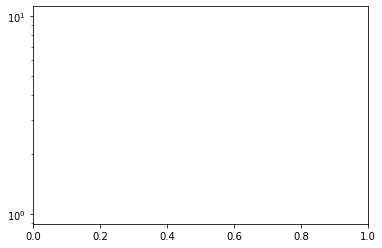

In [178]:
hist_plot = sns.lineplot(data=hist_df.loc[1:])
hist_plot.set(yscale="log")

## Evaluation of the Model

In [192]:
scores = model.predict(np.stack(data.loc[:, "difference"]), batch_size=256, verbose=1)
data["EstimatedDistance"] = np.squeeze(scores)
data["Error"] = (data["EstimatedDistance"].values - data["distance"].values) ** 2


9591/9591 [==============================] - 6s 637us/step


In [193]:
# test error
print(f"Total Sum of Squares: {np.sum(data['Error'].values, axis=0)}")
print(f"MSE: {np.mean(data['Error'].values, axis=0)}")



Total Sum of Squares: 2208974236.2465177
MSE: 899.7125432740786


In [194]:
accuracy = list()
columns = ["EnvironmentID", "NumGoals", "Accuracy"]
acc_df = pd.DataFrame(columns=columns)

for idx, env in env_metadata.iterrows():
    df = data[data.environment == idx]
    if len(df) == 0:
        continue
    true_goal = df["distance"].values.reshape((-1, env.NumGoals))
    estimated_goal = df["EstimatedDistance"].values.reshape((-1, env.NumGoals))

    tmp = tf.keras.metrics.CategoricalAccuracy()
    tmp.update_state(true_goal, estimated_goal)
    acc = tmp.result().numpy()
    accuracy.append(acc)
    tmp_df = pd.DataFrame([(idx, env.NumGoals, acc)], columns=columns)
    acc_df = acc_df.append(tmp_df)

acc_df["Train/Test"] = "Test"
acc_df.loc[acc_df.EnvironmentID == 0, "Train/Test"] = "Train"

print(f"Training Accuracy: {acc_df[acc_df['Train/Test'] == 'Train'].Accuracy.mean()}")
print(f"Test Accuracy: {acc_df[acc_df['Train/Test'] == 'Test'].Accuracy.mean()}")


Training Accuracy: 0.9803463220596313
Test Accuracy: 0.8580726832151413


<AxesSubplot:xlabel='EnvironmentID', ylabel='Accuracy'>

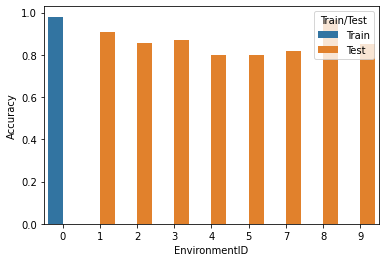

In [195]:
sns.barplot(data=acc_df, x="EnvironmentID", y="Accuracy", hue="Train/Test")

<AxesSubplot:xlabel='NumGoals', ylabel='Accuracy'>

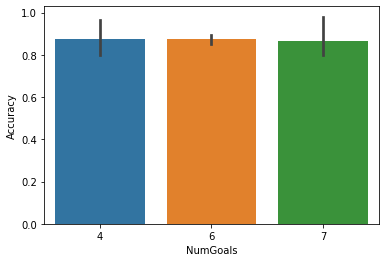

In [196]:
sns.barplot(data=acc_df, x="NumGoals", y="Accuracy")


MSE by number of goals in the environment averaged over the test set (only contains unseen environments)

<AxesSubplot:xlabel='NumGoals', ylabel='Error'>

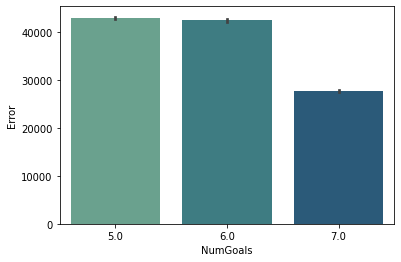

In [51]:

sns.barplot(data=df_score[df_score.EnvironmentID != 0], x="NumGoals", y="Error", palette="crest")

In [ ]:
import seaborn as sns

scoring_df = df_score.copy()
scores = model.predict(np.vstack((train_distances, test_distances)))
scoring_df["Score"] = (scores - scoring_df["Score"]) ** 2

grid = sns.FacetGrid(scoring_df, col="NumGoals", height=3)
grid.map(sns.barplot, "EnvironmentID", "Score", order=np.arange(10))